In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
import statsmodels.stats.multitest as multi
%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

In [2]:
df_listings = pd.read_csv('C:/Users/ryanv/OneDrive/Desktop/Seattle_airbnb_data/listings.csv')

In [3]:
df_listings.shape

(3818, 92)


THIS NOTEBOOOK FOLLOWS A CRSP-DM METHODOLOGY:
1. BUSINESS UNDERSTANDING
2. DATA UNDERSTANDING
3. DATA PREPARATION
4. DATA MODELING
5. EVALUATE THE RESULTS


# Step 1: Business Understanding

#### In this project we are interested in using the Airbnb Seattle Open Dataset to 
#### predict listing prices and total monthly revenue for listings. This is very valuable
#### for Airbnb because it is essential that each listing is priced accurately

## Question 1: Can we predict listing prices with a lasso model?

## Question 2: What features have the strongest effect for predicting prices?

## Question 3: Can we predict listing monthly revenue with a lasso model?

## Question 4: What features have the strongest effect for predicting monthly revenue?

# Step 2: Data Understanding

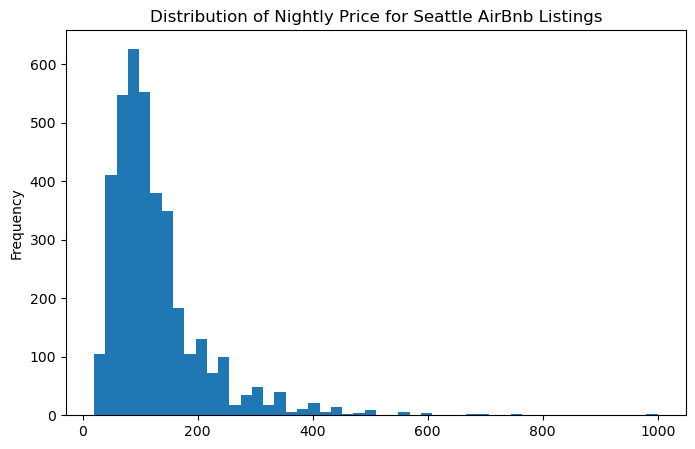

In [4]:
#visualize the distribtion of nightly price / target variable
# We must perform a couple of data cleaning steps in order to generate a histogram of monthly prices
df_listings.price = df_listings.price.str.replace(r"$","").str.replace(",","").astype("float32");
df_listings['price'] = df_listings['price'].astype("float32")

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
df_listings.price.plot(kind = "hist", bins=50)
plt.title("Distribution of Nightly Price for Seattle AirBnb Listings")
plt.show()

In [5]:
# Examining the distribution of price above it looks like the majority of values fall between 0 and 200 with some 
# outliers on the right

In [6]:
# Lets take a look at our data:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,2.016010e+13,1/4/2016,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,8/11/2011,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,...,t,14,41,71,346,1/4/2016,207,11/1/2011,1/2/2016,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,2.016010e+13,1/4/2016,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2/21/2013,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,...,t,13,13,16,291,1/4/2016,43,8/19/2013,12/29/2015,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,2.016010e+13,1/4/2016,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,https://a2.muscache.com/ac/pictures/b4324e0f-a...,NaN,16708587,https://www.airbnb.com/users/show/16708587,Jill,6/12/2014,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,...,t,1,6,17,220,1/4/2016,20,7/30/2014,9/3/2015,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,2.016010e+13,1/4/2016,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/94146944/6...,NaN,9851441,https://www.airbnb.com/users/show/9851441,Emily,11/6/2013,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,...,t,0,0,0,143,1/4/2016,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,2.016010e+13,1/4/2016,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,NaN,NaN,https://a1.muscache.com/ac/pictures/6120468/b0...,NaN,1452570,ht

In [7]:
# Lets also take a look at a list of our columns and the associated data type of each:

df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   float64
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [8]:
#Looking through the columns looks like there is a lot of text data that will need to be manipulated and cleaned!!

In [9]:
# Lets also take a look at the size of our dataset

num_rows = df_listings.shape[0] #Provide the number of rows in the dataset
num_cols = df_listings.shape[1] #Provide the number of columns in the dataset

print(num_rows, num_cols)

3818 92


For next portion of the data understanding section I will visualize and explore several varaibles which I think will be key features in the models

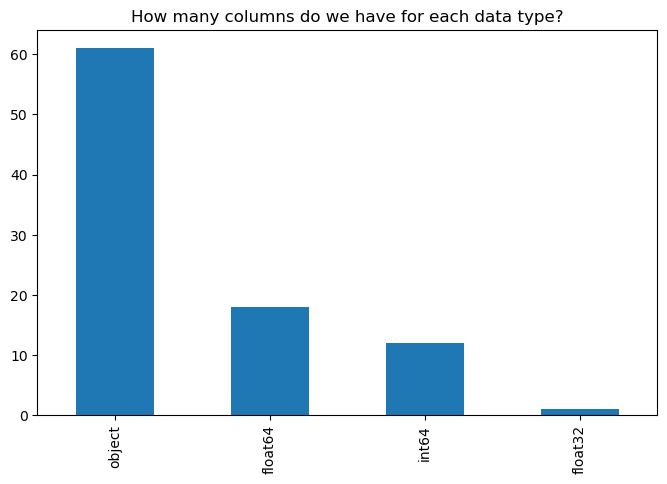

In [10]:
# Lets take a look at the number of columns we have for each data type

df_listings.dtypes.value_counts().plot(kind="bar")
plt.title("How many columns do we have for each data type?");

In [11]:
# Looks like most of our data is string. We will need to one hot encode some of this data for categorical model features 
# And some of this text data will be dropped as it is not useful for training a statistical model

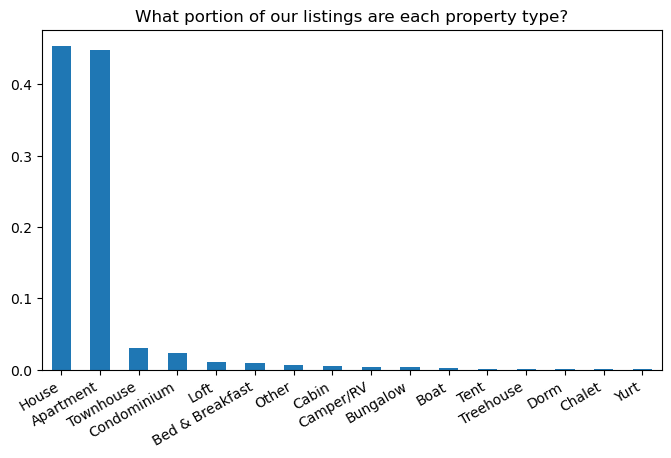

In [12]:
# I want to examine the portion of our data that is each property type as this is likely to be an important factor!

status_vals = df_listings.property_type.value_counts()#Provide a pandas series of the counts for each property type

fig, ax = plt.subplots()
(status_vals/df_listings.shape[0]).plot(kind="bar");
ax.figure.autofmt_xdate()
plt.title("What portion of our listings are each property type?");

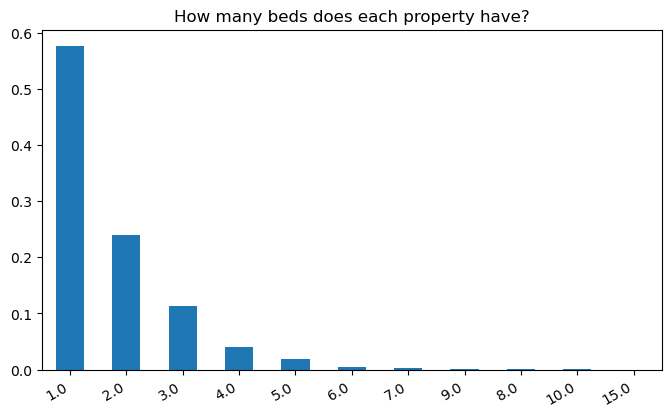

In [13]:
# I want to examine the distribution of amount of beds for each property as this is likely to be an important factor!

status_vals = df_listings.beds.value_counts()#Provide a pandas series of the counts for each property type

fig, ax = plt.subplots()
(status_vals/df_listings.shape[0]).plot(kind="bar");
ax.figure.autofmt_xdate()
plt.title("How many beds does each property have?");

In [14]:
# I am surprised by the amount of listings with only one bed as many customers look at airbnb as an option for groups!

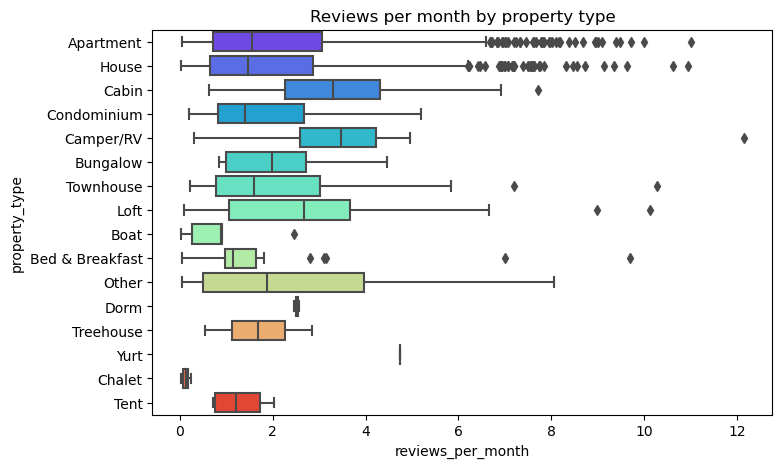

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x='reviews_per_month',y='property_type',data=df_listings, palette='rainbow')
plt.title("Reviews per month by property type");

#Below we are taking a look at reviews per month based on property type
#For generating high monthly revenue for a property it is very important that it is being booked often
#We use reviews per month with an adjustment to estimate bookings per month per property
#It is very interesting to note that there are many Apartments and homes with outliers in booking frequency
#It is also surprising that the median Apartment and Home is only reviewed about twice per month

In [16]:
# With the exception of a very strong relationship between price and weekly and monthly price I would say for the most part
# our numerical variables have relatively low correlation to each other

### Missing Values Analysis and Justification

In [17]:
#Calculate and view the percantage of null values for each column

#print((df_listings.isnull().sum()/ len(df_listings)).sort_values(ascending=False).head(50))
null_series = (df_listings.isnull().sum()/ len(df_listings)).sort_values(ascending=False).head(50)
print(f'There are {len(null_series[null_series > 0])} columns with at least 1 missing value')
print(f'There are {len(null_series[null_series > .10])} columns with at least 10% missing values')
print('Shown below is columns with at least 10% missing values')
print(null_series[null_series > .10])

There are 45 columns with at least 1 missing value
There are 25 columns with at least 10% missing values
Shown below is columns with at least 10% missing values
license                        1.000000
square_feet                    0.974594
monthly_price                  0.602672
security_deposit               0.511262
weekly_price                   0.473808
notes                          0.420639
neighborhood_overview          0.270299
cleaning_fee                   0.269775
transit                        0.244631
host_about                     0.224987
host_acceptance_rate           0.202462
review_scores_accuracy         0.172342
review_scores_checkin          0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
last_review                    0.164222
first_review                   0.164222
reviews_per_month              0.164222

At first look we have 45 columns with at least one missing value. For anything with less than 10% missing it is worth imputing the mean, median or mode depending on the datatype because we do not want to drop the data and potentially lose valuable information for training our model. 

Based on the above we will also drop square_feet, monthly_price, security_deposit and weekly_price because over 45% missing values is too many and we lose much of the signal to potentially be found from that information. Also we cannot use monthly_price and weekly_price to predict price because that will lead to overfitting. Our goal is to try to build a model to predict at what price a new listing should be listed at. 


In [18]:
# Drop column square_feet, monthly_price, weekly_price, security deposit for containing too many NA values [97.5%,60%,51%,47%]

df_listings.drop(["square_feet",'monthly_price','weekly_price','security_deposit'],axis=1,inplace=True)



For this dataset some significant data cleaning is required before we can impute the missing values. This is because there are many columns that are intended to be numeric and boolean but the data is not in the right data type as of now. within the data preparation section we will return to the missing values analysis and we will perform data imputation.

# Step 3: Data Preparation

In [19]:
# Retrieve the creation date of the dataframe for feature engineering
df_listing_last_scraped = pd.Timestamp(df_listings.at[0,'last_scraped'])

# Drop duplicate columns
df_listings = df_listings.T.drop_duplicates().T

# Drop columns with full NA
df_listings.dropna(axis=1,how="all",inplace=True)

# Drop columns with only one unique value
df_listings.drop([c for c in df_listings.columns if df_listings[c].nunique()==1],axis=1,inplace=True)

# Drop columns representing url
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")],axis=1,inplace=True)

# Reformat the money related columns
df_listings.cleaning_fee = df_listings.cleaning_fee.str.replace(r"$","").str.replace(",","").astype("float32");
df_listings.extra_people = df_listings.extra_people.str.replace(r"$","").str.replace(",","").astype("float32");

# Transform the date related columns
df_listings['host_since_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.host_since)).dt.days
df_listings['last_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.last_review)).dt.days
df_listings['first_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.first_review)).dt.days


# Reformat other features
df_listings['host_response_time'] = df_listings.host_response_time.map({"within an hour":1,"within a few hours":12,\
                                                                        "within a day":24,"a few days or more":48})
df_listings.host_response_rate = df_listings.host_response_rate.str.replace("%","").astype("float32")
df_listings['cancellation_policy'] = df_listings['cancellation_policy'].map({'strict':0,'moderate':1,'flexible':2})

# Create a feature count the number of host verification methods
host_verifications = np.unique(np.concatenate(df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", "))))[1:]
matrix_verifications=[[veri in row for row in df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", ")) ] for veri in host_verifications]
df_listings['host_verificationCount'] = pd.DataFrame(matrix_verifications,index=host_verifications).T.sum(1)

In [20]:
df_listings.shape

(3818, 72)

In [21]:
def add_target_columns(df_listings):
    """
    This function adds the target columns Estimated_bookings and Estimated_monthly_revenue to the dataframe.
    
    Parameters:
    df_listings : Dataframe of listings data
    
    Returns:
    df_listings : Dataframe of listings data with added target columns
    
    """
    df_listings['Estimated_bookings'] = df_listings.reviews_per_month.astype('float') * .50
    df_listings['Estimated_monthly_revenue'] = df_listings['Estimated_bookings'] * df_listings['price']
    
    return df_listings
    

In [22]:
df_listings = add_target_columns(df_listings)

In [23]:
#Manually filter the dataset for relevant features

features_host = ['host_is_superhost','host_about','host_response_time','host_response_rate', 'host_listings_count',
                 'host_verificationCount','host_has_profile_pic','host_identity_verified','host_since_deltaDays',\
                 'calculated_host_listings_count']

features_property = ['summary','space','description','neighborhood_overview','notes','transit',
                     'street','neighbourhood','zipcode','latitude','longitude','is_location_exact',
                     'property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type',
                     'amenities','price','cleaning_fee',
                     'guests_included','extra_people','minimum_nights','maximum_nights']

features_traveler = ['number_of_reviews','last_review_deltaDays','first_review_deltaDays','review_scores_rating',
                     'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                     'review_scores_location','review_scores_value','instant_bookable','cancellation_policy',\
                     'require_guest_profile_picture','require_guest_phone_verification','reviews_per_month']

features = features_host + features_property + features_traveler + ['Estimated_bookings', 'Estimated_monthly_revenue']
df_listings_filtered = df_listings[features]

In [24]:
#Prepare features for machine learning model by converting to the correct data types

numeric_feature = ['host_listings_count','calculated_host_listings_count','latitude','longitude','accommodates','bathrooms',
                   'bedrooms','beds','guests_included','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating',
                   'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                   'review_scores_location','review_scores_value', 'review_scores_rating' ,'review_scores_accuracy',
                   'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
                   'review_scores_value' ,'reviews_per_month'] 

bool_feature = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable',
                'require_guest_phone_verification','require_guest_profile_picture']

# Transform the bool features
for bool_f in bool_feature:
    df_listings_filtered[bool_f] = df_listings_filtered[bool_f].map({'t':1,'f':0}).astype('bool')

# Transform the numerical features
for num_f in numeric_feature:
    df_listings_filtered[num_f] = df_listings_filtered[num_f].astype("float32")

In [25]:
# Fix the weird zipcode value
df_listings_filtered.zipcode[df_listings_filtered.zipcode=="99\n98122"] = 98122


In [26]:
#Get list of unique amenities to one hot encode into model inputs

unique_amenities = np.unique(np.concatenate(df_listings_filtered.amenities.str[1:-1].str.replace('"','')
                                            .str.split(",")))[1:]
print(unique_amenities)

['24-Hour Check-in' 'Air Conditioning' 'Breakfast'
 'Buzzer/Wireless Intercom' 'Cable TV' 'Carbon Monoxide Detector' 'Cat(s)'
 'Dog(s)' 'Doorman' 'Dryer' 'Elevator in Building' 'Essentials'
 'Family/Kid Friendly' 'Fire Extinguisher' 'First Aid Kit'
 'Free Parking on Premises' 'Gym' 'Hair Dryer' 'Hangers' 'Heating'
 'Hot Tub' 'Indoor Fireplace' 'Internet' 'Iron' 'Kitchen'
 'Laptop Friendly Workspace' 'Lock on Bedroom Door' 'Other pet(s)'
 'Pets Allowed' 'Pets live on this property' 'Pool' 'Safety Card'
 'Shampoo' 'Smoke Detector' 'Smoking Allowed' 'Suitable for Events' 'TV'
 'Washer' 'Washer / Dryer' 'Wheelchair Accessible' 'Wireless Internet']


In [27]:
matrix_amenities=[[amen in row for row in df_listings_filtered.amenities.str[1:-1].str.replace('"','').
                   str.split(",") ] for amen in unique_amenities]
df_amenities = pd.DataFrame(matrix_amenities,index=unique_amenities).T

# Drop amenities features appear in less than 5% of samples to avoid overfitting
df_amenities.drop(df_amenities.columns.values[np.where(df_amenities.mean()<0.05)],axis=1,inplace=True)
df_listings_filtered_amenities = pd.concat([df_listings_filtered,df_amenities],axis=1)

### Missing values analysis and imputation continued

Now that we having cleaned our data to be in the correct datatypes we can impute the missing values for columns we want to keep. First we examine the new portions of missing data after we have performed some data cleaning and then we impute missing values. 

Here is how each datatype will be imputed:
For numerical features I replaced missing values with the median value of the available data. This approach is robust to the presence of outliers and avoids distorting the distribution of the variable.

For categorical features I imputed the missing values with the most frequent category, which is also known as the mode. This method preserves the distribution of the variable and is suitable for nominal or ordinal data.

In [28]:
#Calculate and view the percantage of null values for each column

print(df_listings_filtered_amenities.isna().mean().sort_values(ascending=False).head(35))

notes                          0.420639
neighborhood_overview          0.270299
cleaning_fee                   0.269775
transit                        0.244631
host_about                     0.224987
review_scores_accuracy         0.172342
review_scores_checkin          0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
reviews_per_month              0.164222
last_review_deltaDays          0.164222
Estimated_bookings             0.164222
first_review_deltaDays         0.164222
Estimated_monthly_revenue      0.164222
space                          0.149031
host_response_time             0.136983
host_response_rate             0.136983
neighbourhood                  0.108958
summary                        0.046359
bathrooms                      0.004191
zipcode                        0.001833
bedrooms                       0.001572


In [29]:
# Final round of data cleaning before we are ready to model!

df_listings_filtered_amenities_cleaned = df_listings_filtered_amenities.copy()

# Fill NA for numeric features
df_listings_filtered_amenities_cleaned.zipcode = df_listings_filtered_amenities_cleaned.zipcode.fillna(
                                                df_listings_filtered_amenities_cleaned.zipcode.mode()[0])
feature_fillna_median = ['host_response_time','host_response_rate','cleaning_fee','bedrooms',
                         'bathrooms','review_scores_rating','review_scores_communication','review_scores_cleanliness','review_scores_location',
                         'review_scores_value','review_scores_accuracy','review_scores_checkin', 'beds', 'host_listings_count',
                         'host_since_deltaDays', 'last_review_deltaDays', 'first_review_deltaDays', 'reviews_per_month'
                        ]
df_listings_filtered_amenities_cleaned[feature_fillna_median] = df_listings_filtered_amenities_cleaned[feature_fillna_median].fillna(
                                                                df_listings_filtered_amenities_cleaned[feature_fillna_median].median())

# Fill NA for object features
feature_fillna_empty =  ['summary','neighbourhood','space','host_about','transit','neighborhood_overview','notes']
df_listings_filtered_amenities_cleaned[feature_fillna_empty] = df_listings_filtered_amenities_cleaned[feature_fillna_empty].fillna(
                                                                df_listings_filtered_amenities_cleaned[feature_fillna_empty].mode())

# Numerical features
df_num = df_listings_filtered_amenities_cleaned.select_dtypes(exclude='object')
# One hot encoding categorical features
df_cat = pd.get_dummies(df_listings_filtered_amenities_cleaned.select_dtypes(include='object')[['property_type','room_type', 'bed_type']])
# Drop one hot categorical feature columns appearing less then 5% of samples
catFeatureToDrop = df_cat.columns.where(df_cat.mean()<0.05).dropna()
df_cat.drop(catFeatureToDrop,axis=1,inplace=True)
df_cat = df_cat.astype("bool")

target_cols = ['price','Estimated_monthly_revenue']
df_total = pd.concat([df_num,df_cat,df_listings_filtered_amenities_cleaned[target_cols]],axis=1)




# Step 4: Data Modeling

### Question 1: Can we predict prices with a lasso model?

In [30]:
# Fit ridge regression model for predicting price

X = df_total.drop(['price','Estimated_bookings','Estimated_monthly_revenue'],axis=1)
y = df_total.price
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:0.589


# Step 5: Evaluate the results

### Question 2: What features are most important for predicting prices?

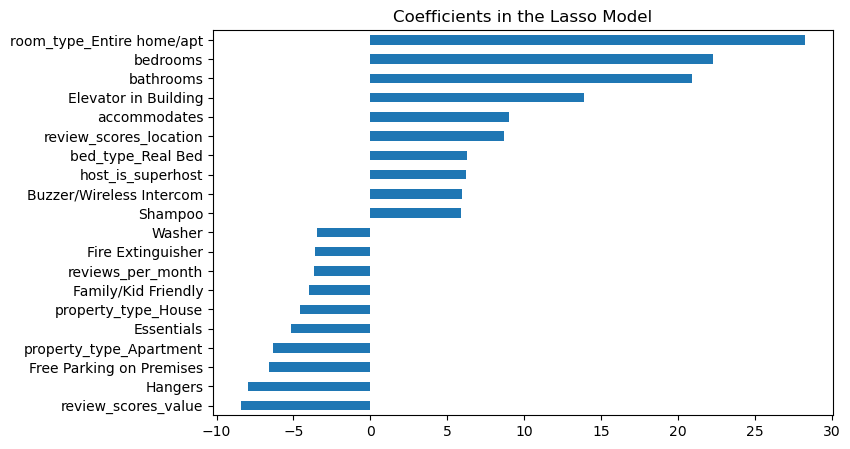

In [31]:
# Visualize coefficient of the ridge regression model

coef = pd.Series(clf.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

# Data Modeling Part 2

### Question 3: Can we predict monthly revenue with a lasso model?

In [32]:
# Fit ridge regression model for predicting monthly revenue

df_total = df_total[df_total['Estimated_monthly_revenue'].notna()]

X = df_total.drop(['price','Estimated_bookings','reviews_per_month','Estimated_monthly_revenue'],axis=1)
y = df_total.Estimated_monthly_revenue
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:0.476


# Evaluate the Results

### Question 4: What features are most important for predicting monthly revenue?

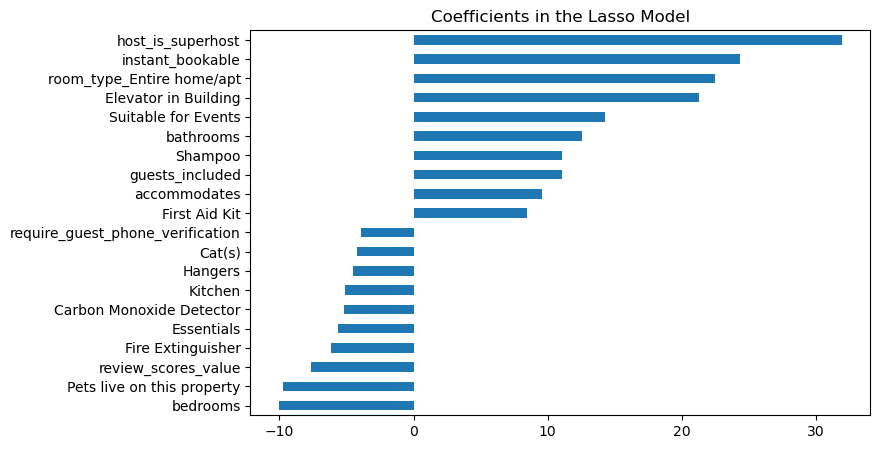

In [33]:
# Visualize coefficient of the ridge regression model

coef = pd.Series(clf.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()